In [1]:
import heyoka as hy
import numpy as np
import time
import os
import pickle

from scipy.optimize import least_squares, root_scalar
from copy import copy, deepcopy

from src.hamiltonian_operations import *
from src.initial_guesses import *
from src.diff_corr import *
from src.miscellaneous import *
from src.ta_construction import *


from matplotlib.pylab import plt

%matplotlib widget

# Define input 

Get periodic orbit initial guess

In [2]:
mu = 0.01215057
# We find the postiion of the lagrangian points
xl_list = find_lagrange_points(mu)
xL1, xL2, xL3, (xL4, yL4), (xL5, yL5) = xl_list[1], xl_list[2], xl_list[0], (xl_list[3][0], xl_list[3][1]), (xl_list[4][0], xl_list[4][1])

xL = xL1
xL_str = 'xL1'

# Get variables

### Lyapunov

In [3]:
use_real = False
direction = False
po_ic, po_period = get_po_ig(xL, mu, use_real=use_real, direction=direction, conj_mom=True)

### Halo

### Setup

In [4]:
init_cond_var = np.eye(6).reshape((36,)).tolist()
ta = get_ta_var(po_ic, ic_var=init_cond_var, conj_mom=True)

In [5]:
nsteps = 2000
epochs = np.linspace(0, po_period, nsteps)

In [6]:
ta.pars[0] = mu
ta.time = 0
ta.state[:] = po_ic + np.eye(6).reshape((36,)).tolist()
out2 = ta.propagate_grid(epochs)
out2 = out2[5]

In [7]:
ta, ic, err = diff_corr_phasing(ta, po_ic, tol=1e-12, max_iter=100, conj_mom=True)
t_final = ic[6]
ic = ic[:6]
# ic, t_final, ds, out = perform_predictor_corrector_step(ta, np.array(po_ic), po_period, ds=1e-4, verbose=True)
# out, _ = find_po_family(ta, np.array(po_ic), po_period, ds=1e-6, max_iter=30, verbose=True)

In [8]:
timesteps = np.linspace(0, t_final, 2000)
ta.time = 0.
ta.state[:] = ic.tolist() + init_cond_var
out3 = ta.propagate_grid(timesteps)
out3 = out3[5]

Starting point

In [9]:
new_ic = ic
new_period = t_final

# Perform PA Continuation

In [10]:
verbose = True
start_time = time.time()
max_iter = 100
ds = 1e-4# We call the predictor
# Main iterations
out, _ = find_po_family(ta, new_ic, new_period, ds, max_iter=max_iter, corr_max_iter=100, verbose=verbose)

ds: 0.0001 err: [3.11467433e-13]
Converged - increase ds
ds: 0.00011000000000000002 err: [2.26261497e-13]
Converged - increase ds
ds: 0.00012100000000000003 err: [8.62584349e-14]
Converged - increase ds
ds: 0.00013310000000000004 err: [1.24123333e-13]
Converged - increase ds
ds: 0.00014641000000000006 err: [1.37482178e-13]
Converged - increase ds
ds: 0.00016105100000000008 err: [8.02700609e-14]
Converged - increase ds
ds: 0.0001771561000000001 err: [3.09737523e-16]
Converged - increase ds
ds: 0.00019487171000000012 err: [5.37765391e-13]
Converged - increase ds
ds: 0.00021435888100000014 err: [1.82241411e-13]
Converged - increase ds
ds: 0.00023579476910000016 err: [5.94943801e-16]
Converged - increase ds
ds: 0.00025937424601000017 err: [1.80810246e-13]
Converged - increase ds
ds: 0.0002853116706110002 err: [5.89648407e-14]
Converged - increase ds
ds: 0.00031384283767210024 err: [1.81638475e-13]
Converged - increase ds
ds: 0.0003452271214393103 err: [1.98228973e-13]
Converged - increase 

# Plotting

## 2D Plot for Lyapunov

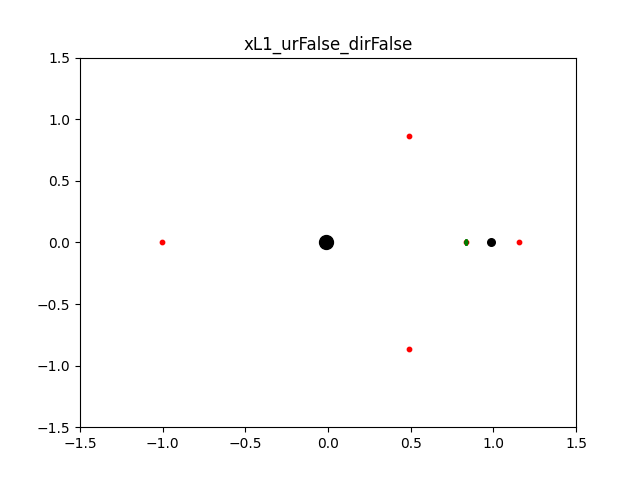

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#Plot the lagrangian points and primaries
fig_name = f'{xL_str}_ur{use_real}_dir{direction}'
ax.set_title(fig_name)
buffer=1.5
# ax.set_xlim(xL1-buffer, xL1+buffer)
# ax.set_ylim(-buffer, +buffer)
ax.set_xlim(-buffer, buffer)
ax.set_ylim(-buffer, buffer)
ax.scatter(-mu, 0, c='k', s=100)
ax.scatter((1-mu), 0, c='k', s=30)
ax.scatter(xL1, 0, c='r', s=10)
ax.scatter(xL2, 0, c='r', s=10)
ax.scatter(xL3, 0, c='r', s=10)
ax.scatter(xL4, yL4, c='r', s=10)
ax.scatter(xL5, yL5, c='r', s=10)
# # zero velocity curve
#plot_zero_vel_curves(ax, mu, new_ic, xL, buffer=buffer)
# ax.plot(out2[:, 0], out2[:, 1], linewidth=2, c='b')
# ax.scatter(out2[-1, 0], out2[-1, 1], s=5)
# ax.plot(out3[:, 0], out3[:, 1], linewidth=2, c='r')
# ax.scatter(out3[-1, 0], out3[-1, 1], s=5)
for i in out.keys():
    ax.plot(out[i][:, 0], out[i][:, 1],'g', alpha=0.3) if out[i] is not None else None

plt.show()
save_fig=False
if save_fig:
    direc = os.getcwd() + '/figures/'
    fig.savefig(direc + f'{fig_name}.png', dpi=300)

## 3D Plot for Halo etc.